In [29]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets
                  where (date_time >= NOW() - '7 day'::INTERVAL);'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [31]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'lphhavftgd',
 b'ktkzfnpuhr',
 b'tweet_tfidf_fit',
 b'hashtags_countvec_fit_transform',
 b'tweet_SVD_fit',
 b'hashtag_tfidf',
 b'temp_hash_count_12hr',
 b'tweets_tfd_svd_pipe',
 b'xducctihks',
 b'a',
 b'tweet_tfidf_fit_transform',
 b'hashtags_countvec_fit',
 b'hashtags_countvec_fit_temp',
 b'hashtags_tfidf_fit_transform']

In [32]:
tfd_svd_pipe = pickle.loads(r.get('tweets_tfd_svd_pipe'))

In [33]:
TFIDF_fit =  tfd_svd_pipe.steps[0][1]
SVD_fit = tfd_svd_pipe.steps[1][1]

TFIDF_fit = pickle.loads(r.get('tweet_tfidf_fit'))
SVD_fit = pickle.loads(r.get('tweet_SVD_fit'))

In [34]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [35]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',round(a1a2,3),'\n'
                'B1|B2: ',round(b1b2,3), '\n\n'
                'A1|B1: ',round(a1b1,3), '\n'
                'A2|B2: ', round(a2b2,3), '\n\n'
                'Cosine Similarity Mean of A2 to A1', round(a2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to B1', round(b2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to A1', round(a1b2_mean,3), '\n\n'
                'Cosine Similarity STD of A2 to A1', round(a2_std,3), '\n'
                'Cosine Similarity STD of B2 to B1', round(b2_std,3), '\n'
                'Cosine Similarity STD of B2 to A1', round(a1b2_std,3), '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [36]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [37]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

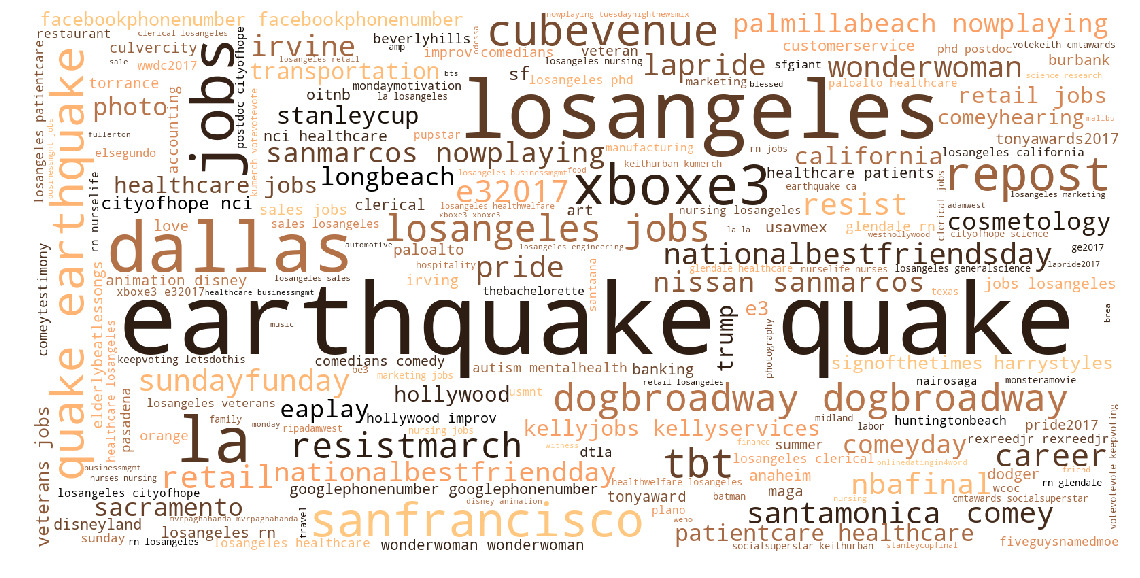

In [38]:
words = df['hashtags'][(df['hashtags'].isnull() == False) & (df['hashtags'] != 'None')]
stopwords = set(STOPWORDS)
stopwords.add("job")
stopwords.add("careerarc")
stopwords.add("hiring")
wc = WordCloud(width=1600, height=800, background_color='white', \
               relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Event Tweets (earthquake|quake):  1000
A1|A2:  0.999 
B1|B2:  0.965 

A1|B1:  0.337 
A2|B2:  0.264 

Cosine Similarity Mean of A2 to A1 0.822 
Cosine Similarity Mean of B2 to B1 0.299 
Cosine Similarity Mean of B2 to A1 0.066 

Cosine Similarity STD of A2 to A1 0.232 
Cosine Similarity STD of B2 to B1 0.121 
Cosine Similarity STD of B2 to A1 0.124 



(-0.1, 1)

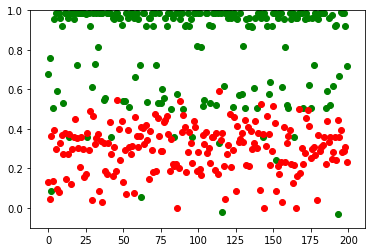

In [39]:
print('Event Tweets (earthquake|quake): ', event_tweet_count('earthquake|quake'))
A, B = tweets_event_ab_test('earthquake|quake')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

In [42]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('earthquake|quake',.5)

,index,score,tweet,index,score,tweet
0,133,0.987694,"usgs reports a m1.48 #earthquake 9km sse of malibu beach, ca on 6/7/17 @ 12:37:47 utc #quake",280,0.549290,"1.8 magnitude #earthquake. 12 km from mammoth lakes, #ca, united states"
1,65,0.987415,"usgs reports a m1.48 #earthquake 4km nw of newport beach, ca on 6/5/17 @ 13:23:59 utc #quake",278,0.546915,"2.6 magnitude #earthquake. 26 km from king city, ca, #unitedstates"
2,244,0.987415,"usgs reports a m1.48 #earthquake 4km nw of newport beach, ca on 6/5/17 @ 13:23:59 utc #quake",151,0.545432,"california, united states ml 3.3 (114 min ago) 3.0km 38.82°n 122.81°w jun 6, 2017 01:49:38 utc #earthquake"
3,32,0.986060,"usgs reports a m1.42 #earthquake 13km wnw of salton city, ca on 6/6/17 @ 23:39:21 utc #quake",172,0.543607,"california, united states ml 2.1 (243 min ago) 14.0km 33.64°n 116.72°w jun 9, 2017 15:26:51 utc #earthquake"
4,402,0.985844,"usgs reports a m1.28 #earthquake 15km s of salton city, ca on 6/5/17 @ 22:57:27 utc #quake",17,0.540166,"2.3 magnitude #earthquake. 11 mi from #aguanga, ca, united states"
5,421,0.985844,"usgs reports a m1.28 #earthquake 15km s of salton city, ca on 6/5/17 @ 22:57:27 utc #quake",4,0.537217,"2.1 magnitude #earthquake. 11 km from humboldt hill, #ca, united states"
6,335,0.985728,"usgs reports a m1.37 #earthquake 14km w of salton city, ca on 6/7/17 @ 4:54:34 utc #quake",13,0.535817,"1.7 magnitude #earthquake. 16 km from mammoth lakes, #ca, united states"
7,77,0.985718,"usgs reports a m1.21 #earthquake 3km sw of macarthur park, ca on 6/6/17 @ 23:31:23 utc #quake",494,0.532550,"2.5 magnitude #earthquake. 10 km from dunnigan, ca, #unitedstates"
8,183,0.985718,"usgs reports a m1.21 #earthquake 3km sw of macarthur park, ca on 6/6/17 @ 23:31:23 utc #quake",94,0.530163,"2.4 magnitude #earthquake. 24 km from kettleman city, ca, #unitedstates"
9,392,0.985704,"usgs reports a m1.22 #earthquake 19km e of little lake, ca on 6/11/17 @ 21:57:45 utc #quake",313,0.528602,"1.5 magnitude #earthquake. 12 km from morongo valley, #ca, united states"


In [41]:
Top_scored_tweets_in_B('earthquake|quake', n = 300000)

,score,tweet
230283,0.960476,#couchafornia #freecouch #shermanoaks #hobosolutions #alleyways #allies 6.3.17 discovered…
229169,0.952706,jomola 2pcs kitchen sink liquid soap dispenser stainless steel brushed finish13oz combination discount price：$17.9…
70701,0.952128,rocksteady: 3-6-17
78331,0.951865,dreamspun... ✨❤☕✖⭐✨ | 6.5.17 shopstyle #shopstyleit…
37830,0.951755,17 daysssss
47629,0.950101,"""globaltakeover"" '17 #35mm #film #filmphotography"
291590,0.946500,summa '17 🤷‍♀️
295785,0.944914,fight on✌ @ university of southern california
142191,0.941547,#ripamericansoldiers #6/9/17 #marines #army #navy #airforce #coastguard @ american river…
70968,0.941500,1995 // city of muguets // available online 06/12 // (link on bio)
